Análise do dia 03/04 através do modelo LDA.

In [1]:
# Importar bibliotecas

# gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from ast import literal_eval

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Criando stopwords em português utilizando a biblioteca nltk

nlp = spacy.load("pt_core_news_sm")
pt_stopwords = sorted([token.text for token in nlp.vocab if token.is_stop])
list_exclude = ['obrigado', 'bom', 'mal', 'nenhuma', 'maior', 
             'bem', 'não', 'máximo', 'boa', 'mais',
               'bastante', 'certamente', 'certeza', 'contra',
                'quarentena', 'coronavírus', 'presidente', 'impeachment', 'demitido', 'demitida']
for word in list_exclude:
    nlp.vocab[word].is_stop = False
list_include = set(['o', 'a', 'tá', 'ta', 'ser', 'pro', 'to', 'tô', 'vc', 'você', 'voce', 'pra',
                    'pq', 'é', 'vou', 'que','tão', 'gt', 'de', 'da', 'do', 'em', 'uma', 'lá',
                    'já', 'no', 'para', 'na', 'com', 'um', 'minha', 'se', 'isso', 'por', 'vou',
                    'os', 'isso', 'como', 'mesmo', 'tenho', 'aqui', 'ele', 'ela', 'quem', 'fazer',
                    'eu', 'só', 'ai', 'mais', 'só', 'querer', 'https', 'ter', 'estar', 'ficar',
                    'dos', 'das', 'vcs', 'jairbolsonaro', 'tava', 'nao', 'sao', 'ja', 'so', 'nossa',
                    'nosso', 'estao', 'tco', 'me', 'dia', 'te', 'ver', 'sera', 'porra', 'fez', 'ne',
                    'kkkkkk', 'puta', 'kkkkkkkk', 'hj', 'afff', 'gbr', 'meu', 'cara', 'guri', 'cmg',
                    'ctg', 'agr', 'pqp', 'vdd', 'eh', 'va', 'fudeu', 'fuder', 'fodeu', 'foda', 'obg',
                   'nem', 'numa', 'num', 'nuns', 'ces', 'voces', 'oce', 'oces', 'kkkk', 'vao', 'via',
                    'hj', 'hoje', 'tudo', 'todo', 'toda', 'ir', 'vir', 'bem', 'sair', 'tao']
                  )
for w in list_include:
    nlp.vocab[w].is_stop = True
stop_words = sorted([token.text for token in nlp.vocab if token.is_stop])

# Preparação dos dados

In [3]:
# import dos dados

df = pd.read_csv('0403_preprocessado.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# import dos tokens

df_tokens = pd.read_csv('tokens_unicos_10k.csv')

In [5]:
# criação de lista de tokens

lista_token = []

for row in range(0, len(df_tokens)):
    lista_token.append(df_tokens.iloc[row,1])
    
lista_token = set(lista_token)

In [6]:
# filtranso os tokens para aparecer apenas os 10 mil mais frequentes

df['token2'] = df.token.apply(lambda x: str(list(set(literal_eval(x)).intersection(lista_token))))

In [7]:
# função para reverter os tokens processados em lista de tuples

def strip_characters(text):
    t = re.sub(r'\(|\)|:|,|;|\.|’|”|“|\?|%|>|<|\[|\]', '', text)
    t = re.sub(r'/', ' ', t)
    t = t.replace("'",'')
    return t

In [8]:
# aplica função em todos os tokens

df['token2'] = df['token2'].apply(lambda x: strip_characters(x))
df['token2'] = df['token2'].apply(lambda x: str(x).split(' '))

In [9]:
# transforma os tokens em lista

lista = list(df['token2'])

In [10]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(lista, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[lista], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# função para preprocessar palavras

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts1 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts2 = [bigram_mod[doc] for doc in texts1]
    texts3 = [trigram_mod[bigram_mod[doc]] for doc in texts2]
    texts4 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts3]    
    return texts4

In [12]:
# Processing the abstract

texto = process_words(lista)

# Modelagem

In [13]:
# Criar dicionário

id2word = corpora.Dictionary(texto)

In [14]:
# Criar o Corpus: A Frequência das palavras nos documentos

corpus = [id2word.doc2bow(text) for text in texto]

In [15]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=30, step=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [07:39<00:00, 32.81s/it]


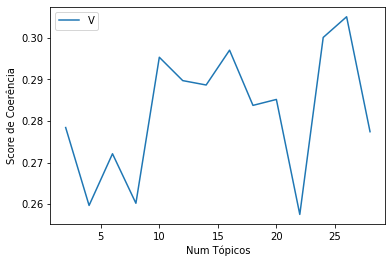

In [17]:
# Mostrando visualmente a quantidade de tópicos

limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [18]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico

for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.2784
A quantidade de tópicos = 4  tem um valor de coerência de  0.2597
A quantidade de tópicos = 6  tem um valor de coerência de  0.2721
A quantidade de tópicos = 8  tem um valor de coerência de  0.2602
A quantidade de tópicos = 10  tem um valor de coerência de  0.2954
A quantidade de tópicos = 12  tem um valor de coerência de  0.2897
A quantidade de tópicos = 14  tem um valor de coerência de  0.2887
A quantidade de tópicos = 16  tem um valor de coerência de  0.2971
A quantidade de tópicos = 18  tem um valor de coerência de  0.2838
A quantidade de tópicos = 20  tem um valor de coerência de  0.2852
A quantidade de tópicos = 22  tem um valor de coerência de  0.2575
A quantidade de tópicos = 24  tem um valor de coerência de  0.3001
A quantidade de tópicos = 26  tem um valor de coerência de  0.3051
A quantidade de tópicos = 28  tem um valor de coerência de  0.2774


Aqui conseguimos determinar a melhor quantidade de tópicos a serem analisados, que é 8 tópicos

In [19]:
# Vamos agora construir de fato o modelo LDA

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=4, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True)

In [20]:
# Computar a perplexidade do modelo (quanto menor, melhor)

print('\nPerplexidade: ', lda_model.log_perplexity(corpus))


Perplexidade:  -7.119972953552391


In [21]:
# Computar o Score de Coerência

coherence_model_lda = CoherenceModel(model=lda_model, texts=lista, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)


Score de Coerência:  0.303997660330972


In [22]:
# Visualização dos tópicos em clusters

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.049107  0.243577       1        1  29.538811
0      0.079164  0.178008       2        1  28.866726
2     -0.376321 -0.125760       3        1  21.869202
1      0.248050 -0.295825       4        1  19.725269, topic_info=            Term          Freq         Total Category  logprob  loglift
2      bolsonaro  19946.000000  19946.000000  Default  30.0000  30.0000
0         corona  14747.000000  14747.000000  Default  29.0000  29.0000
24   coronavirus  14894.000000  14894.000000  Default  28.0000  28.0000
20    presidente  17047.000000  17047.000000  Default  27.0000  27.0000
29      pandemia   9823.000000   9823.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
233        ainda    895.678528   3684.394775   Topic4  -4.9762   0.2090
62           pos    674.112915   1280.135498   Topic4  -5.2604   0.9819
391        mundo    806.823303   3539.958496   Topic4  -5.0807   0.1445
85         merda    677.887817   1628.246704   Topic4  -5.2548   0.7470
380          vez    675.641479   1853.087646   Topic4  -5.2581   0.6143

[200 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
425       3  0.999369    abril
243       2  0.999813   acabar
28        1  0.323287    agora
28        2  0.251701    agora
28        3  0.103049    agora
...     ...       ...      ...
357       2  0.999636     vida
46        4  0.999866    virus
113       2  0.998573    volta
114       2  0.999191   voltar
173       4  0.999683  vontade

[197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [23]:
# Escolhe o modelo

optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.080*"corona" + 0.051*"virus" + 0.040*"presidente" + 0.020*"sim" + '
  '0.016*"hora" + 0.014*"ainda" + 0.014*"quando" + 0.012*"acabar" + '
  '0.012*"agora" + 0.011*"tomar"'),
 (1,
  '0.053*"presidente" + 0.052*"bolsonaro" + 0.031*"brasil" + '
  '0.030*"coronavirus" + 0.027*"mandetta" + 0.024*"saude" + 0.022*"ministro" + '
  '0.019*"melhor" + 0.017*"governo" + 0.013*"ministerio"'),
 (2,
  '0.115*"coronavirus" + 0.079*"pandemia" + 0.018*"meio" + 0.017*"depois" + '
  '0.014*"bolsonaro" + 0.014*"novo" + 0.012*"mundo" + 0.010*"brasil" + '
  '0.010*"qual" + 0.009*"crise"'),
 (3,
  '0.032*"deus" + 0.030*"corona" + 0.022*"logo" + 0.021*"presidente" + '
  '0.014*"gente" + 0.014*"povo" + 0.013*"amor" + 0.013*"vida" + '
  '0.012*"bolsonaro" + 0.012*"video"'),
 (4,
  '0.102*"bolsonaro" + 0.011*"presidente" + 0.011*"oq" + 0.009*"muito" + '
  '0.009*"agora" + 0.009*"jair" + 0.008*"mundo" + 0.008*"robos" + '
  '0.008*"governo" + 0.007*"pandemia"'),
 (5,
  '0.037*"bolsonaro" + 0.028*"presiden

In [24]:
# Encontrar qual o principal tópico em cada tweet

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lista):
    # Output
    sent_topics_df = pd.DataFrame()

    # Seleciona o principal tópico de cada tweet
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => mostra o principal tópico
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']

    # Inclui o texto original no final do DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [25]:
# roda a função de calcular os principais tópicos de cada tweet

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=lista)

In [26]:
# Formata o DataFrame

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']

In [27]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]

# Show
sent_topics_sorteddf_mallet

,Topico,Topico_Perc_Contrib,Palavras_Chave,Tweet
0,0.0,0.9308,"corona, virus, presidente, sim, hora, ainda, q...","[outro, saude, exatamente, ainda, so, https, p..."
1,1.0,0.9500,"presidente, bolsonaro, brasil, coronavirus, ma...","[ainda, jogo, bolsonaro, falar, time, nao, com..."
2,2.0,0.9357,"coronavirus, pandemia, meio, depois, bolsonaro...","[pandemia, verde, mar, planeta, mundo, ja, bor..."
3,3.0,0.9437,"deus, corona, logo, presidente, gente, povo, a...","[hora, dizer, sdds, noite, sera, msm, caseiro,..."
4,4.0,0.9470,"bolsonaro, presidente, oq, muito, agora, jair,...","[dizer, falar, sim, nao, trabalho, das, gay, s..."
5,5.0,0.9500,"bolsonaro, presidente, casa, demais, doria, pa...","[thread, vittar, bolsonaro, cu, papel, boca, t..."
6,6.0,0.9400,"coronavirus, contra, pandemia, bolsonaro, agor...","[sairam, rabo, salarios, saude, bi, dos, etc, ..."
7,7.0,0.9437,"casa, quando, acabar, gente, passar, muito, co...","[semana, comemorar, caso, dia, sp, meu, puglie..."
8,8.0,0.9470,"presidente, bolsonaro, muito, senhor, vez, fim...","[prepotente, senhor, sr, traira, entao, humild..."
9,9.0,0.9307,"corona, virus, final, tanto, mundo, matar, mae...","[fim, temporada, dizer, das, rita, capaz, assi..."


In [28]:
# Numero de tweets por topico

topic_counts = df_topic_sents_keywords['Principal_Topico'].value_counts()

# Porcentagem de tweets por tópico
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Número do tópico e suas palavras chave
topic_num_keywords = df_topic_sents_keywords[['Principal_Topico', 'Palavras_Chave']]

# Concatena as colunas
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomeia as colunas
df_dominant_topics.columns = ['Principal_Topico', 'Palavras_Chave', 'Qtd_Tweets', 'Perc_Tweets']

# Mostra o DataFrame
df_dominant_topics

,Principal_Topico,Palavras_Chave,Qtd_Tweets,Perc_Tweets
0.0,0.0,"corona, virus, presidente, sim, hora, ainda, q...",17574.0,0.1220
1.0,9.0,"corona, virus, final, tanto, mundo, matar, mae...",14282.0,0.0992
2.0,4.0,"bolsonaro, presidente, oq, muito, agora, jair,...",15037.0,0.1044
3.0,7.0,"casa, quando, acabar, gente, passar, muito, co...",10073.0,0.0699
4.0,7.0,"casa, quando, acabar, gente, passar, muito, co...",13090.0,0.0909
...,...,...,...,...
143999.0,3.0,"deus, corona, logo, presidente, gente, povo, a...",NaN,NaN
144000.0,1.0,"presidente, bolsonaro, brasil, coronavirus, ma...",NaN,NaN
144001.0,6.0,"coronavirus, contra, pandemia, bolsonaro, agor...",NaN,NaN
144002.0,6.0,"coronavirus, contra, pandemia, bolsonaro, agor...",NaN,NaN


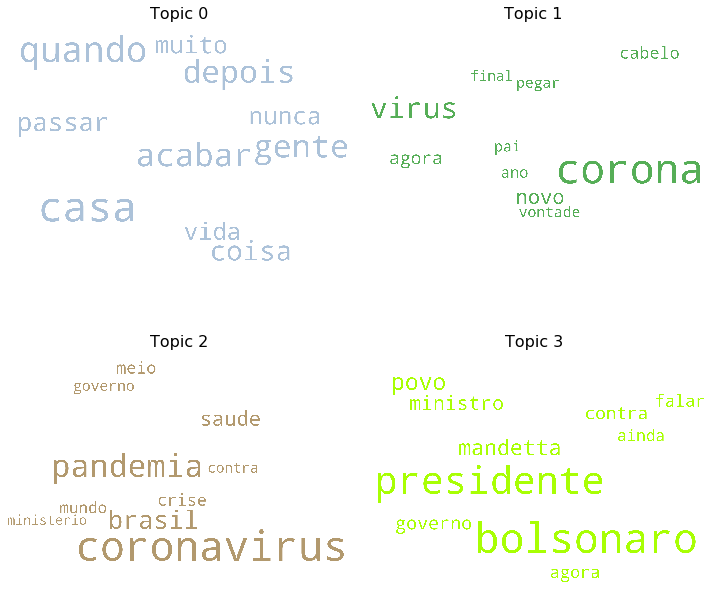

In [29]:
# Cria wordclouds

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()